# Assignment 2
## Dataset: Power Plant Regression (Customized + Outliers)
`usina_with_outliers.csv`
This file contains artificial outliers added to the original dataset.   
Removing outliers: `usina.csv`

In [1]:
# === Imports === #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence # Statsmodels influence diagnostics

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

## Q1 (25 points): Outlier Detection and Removal using Cook’s Distance
- I chose Linear Regression as the model because Cook’s Distance is derived specifically for OLS regression. Using OLS ensures that the influence diagnostics have a clear and standard statistical interpretation.
- I chose Statsmodels OLS as the library because it provides a clean outlier detection workflow with built-in support for influence diagnostics.

In [2]:
def fit_ols_diagnostics(X, y):
    """Fit OLS and return (model, diagnostics dataframe).

    Parameters
    ----------
    X : array-like, shape (n,) or (n, p)
        Feature matrix (without intercept column).
    y : array-like, shape (n,)
        Target vector.
    """
    X = np.asarray(X)
    y = np.asarray(y).reshape(-1)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    # Add intercept column for statsmodels
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()

    infl = OLSInfluence(model)
    diag = pd.DataFrame({
        "y": y,
        "y_hat": model.fittedvalues,
        "residual": model.resid,
        "leverage_hii": infl.hat_matrix_diag,   # diagonal of Hat matrix H
        "cooks_D": infl.cooks_distance[0]
    })
    return model, diag

In [61]:
# Load the dataset
df = pd.read_csv("usina_with_outliers.csv")
df = df.copy()

X = df[['AT', 'V', 'AP', 'RH']]
y = df['PE']

print(X.head())
print(y.head())

      AT      V       AP     RH
0  14.96  41.76  1024.07  73.17
1  25.18  62.96  1020.04  59.08
2   5.11  39.40  1012.16  92.14
3  20.86  57.32  1010.24  76.64
4  10.82  37.50  1009.23  96.62
0    463.26
1    444.37
2    488.56
3    446.48
4    473.90
Name: PE, dtype: float64


In [62]:
# Compute Cook’s Distance
model_full, diag_full = fit_ols_diagnostics(X, y)
print(model_full.summary())

#  Identify outliers 
n = len(df)
threshold = 4 / n
diag_table = diag_full.copy()
diag_table["flag_D_gt_4_over_n"] = diag_table["cooks_D"] > threshold
print(f"Cook's distance heuristic threshold 4/n = {threshold:.3f}")

diag_table_sorted = diag_table.sort_values("cooks_D", ascending=False)
diag_table_sorted.head(10)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     4416.
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        13:12:05   Log-Likelihood:                -36621.
No. Observations:                9568   AIC:                         7.325e+04
Df Residuals:                    9563   BIC:                         7.329e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.7845     19.524      2.447      0.0

,y,y_hat,residual,leverage_hii,cooks_D,flag_D_gt_4_over_n
4228,532.89197,367.627618,165.264352,0.027485,1.283760,True
49,370.64803,515.833750,-145.185720,0.027817,1.003422,True
875,541.43197,408.524788,132.907182,0.032505,0.992133,True
5922,373.10803,481.504793,-108.396763,0.041859,0.866516,True
2538,364.32803,559.133964,-194.805934,0.013496,0.851224,True
5480,358.96803,505.177891,-146.209861,0.023388,0.847862,True
9241,575.06197,410.364058,164.697912,0.017632,0.801592,True
7678,331.77803,476.209310,-144.431280,0.022602,0.798247,True
9525,343.19803,472.982395,-129.784365,0.026271,0.754847,True
9219,536.88197,394.454473,142.427497,0.019136,0.652604,True


In [63]:
# Remove the detected outliers
outlier_idx = diag_table.index[diag_table["flag_D_gt_4_over_n"]]
df_clean = df.drop(index=outlier_idx).reset_index(drop=True)

# Create a new DataFrame without outliers.
df_clean.to_csv("usina.csv", index=False)

## Q2 (20 points): Train/Test Evaluation Before vs After Outlier Removal
- Comparing the results, both training error and test error decrease substantially after removing outliers.  
With outliers Train: {'MSE': 123.38420660332902, 'MAE': 5.1986792395786505, 'R^2': 0.6501705758093679}  
With outliers Test:  {'MSE': 125.11338906020676, 'MAE': 5.052457986837267, 'R^2': 0.6425738281990965}  
Clean dataset Train: {'MSE': 19.864671003981222, 'MAE': 3.59639642173105, 'R^2': 0.9313692265834657}  
Clean dataset Test:  {'MSE': 20.396772456043255, 'MAE': 3.6247726076133877, 'R^2': 0.9303022187088379}  
- The clean dataset without outliers shows better generalization because it has much lower test MAE and MSE, as well as higher R^2, which is close to 1.
- Additionally, the small gap between training and test metrics in the clean dataset indicates it is more stable and reliable.
- Ridge and Lasso regression do not provide a substantial improvement over standard linear regression for this dataset.
- The best Ridge and Lasso models achieve test MSE, MAE, and R² values that are very close to those of linear regression.  
    For Ridge regression, the best performance occurs at lambda = 100, with test MSE = 20.3946, MAE = 3.6249, and R² = 0.9303.  
    For Lasso regression, the best performance occurs at lambda = 0.1, with test MSE = 20.3926, MAE = 3.6249, and R² = 0.9303.

In [64]:
def split_data(X, y, test_size=0.30, random_state=42):
    """70/30 random train-test split."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def compute_metrics(y_true, y_pred):
    """Return MSE, MAE, R^2."""
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R^2": r2_score(y_true, y_pred),
    }

def sweep_model(model_type: str, lambda_grid):
    rows = []
    for lam in lambda_grid:
        if model_type == "Ridge":
            model = Ridge(alpha=float(lam))
        elif model_type == "Lasso":
            model = Lasso(alpha=float(lam), max_iter=50000)
        else:
            raise ValueError("model_type must be 'Ridge' or 'Lasso'")

        model.fit(X_train, y_train)

        pred_tr = model.predict(X_train)
        pred_te = model.predict(X_test)

        mtr = compute_metrics(y_train, pred_tr)
        mte = compute_metrics(y_test, pred_te)

        rows.append({
            "model": model_type,
            "lambda": float(lam),
            **{f"train_{k}": v for k, v in mtr.items()},
            **{f"test_{k}": v for k, v in mte.items()},
        })

    return pd.DataFrame(rows).sort_values("test_MSE").reset_index(drop=True)

In [65]:
# 2.1 Train the above models on usina with outliers.csv and report train/test metrics.
X_train, X_test, y_train, y_test = split_data(X, y)

model = LinearRegression()
model.fit(X_train, y_train)

yhat_train = model.predict(X_train)
yhat_test  = model.predict(X_test)

train_metrics = compute_metrics(y_train, yhat_train)
test_metrics  = compute_metrics(y_test, yhat_test)
print("With outliers Train:", train_metrics)
print("With outliers Test: ", test_metrics)

With outliers Train: {'MSE': 123.38420660332902, 'MAE': 5.1986792395786505, 'R^2': 0.6501705758093679}
With outliers Test:  {'MSE': 125.11338906020676, 'MAE': 5.052457986837267, 'R^2': 0.6425738281990965}


In [66]:
# 2.2 Train the same models on usina.csv and report train/test metrics.
# 2.3 Use the following metrics for both train and test: MAE, MSE, R^2
df_clean = pd.read_csv("usina.csv")
X_clean = df[["AT", "V", "AP", "RH"]]
y_clean = df["PE"]

X_train, X_test, y_train, y_test = split_data(X_clean, y_clean)

model = LinearRegression()
model.fit(X_train, y_train)

train_metrics_clean = compute_metrics(y_train, model.predict(X_train))
test_metrics_clean  = compute_metrics(y_test,  model.predict(X_test))

print("Clean dataset Train:", train_metrics_clean)
print("Clean dataset Test: ", test_metrics_clean)

Clean dataset Train: {'MSE': 123.38420660332902, 'MAE': 5.1986792395786505, 'R^2': 0.6501705758093679}
Clean dataset Test:  {'MSE': 125.11338906020676, 'MAE': 5.052457986837267, 'R^2': 0.6425738281990965}


In [67]:
# 2.4 For Ridge and Lasso, use the following λ values: λ ∈ {0.01, 0.1, 1, 10, 100}
lambda_grid = [0.01, 0.1, 1, 10, 100]
ridge_table = sweep_model("Ridge", lambda_grid)
lasso_table = sweep_model("Lasso", lambda_grid)
display(ridge_table)
display(lasso_table)

,model,lambda,train_MSE,train_MAE,train_R^2,test_MSE,test_MAE,test_R^2
0,Ridge,0.01,123.384207,5.198679,0.650171,125.113389,5.052458,0.642574
1,Ridge,0.10,123.384207,5.198680,0.650171,125.113392,5.052459,0.642574
2,Ridge,1.00,123.384207,5.198685,0.650171,125.113421,5.052463,0.642574
3,Ridge,10.00,123.384207,5.198737,0.650171,125.113705,5.052513,0.642573
4,Ridge,100.00,123.384213,5.199261,0.650171,125.116548,5.053003,0.642565


,model,lambda,train_MSE,train_MAE,train_R^2,test_MSE,test_MAE,test_R^2
0,Lasso,0.01,123.384210,5.198858,0.650171,125.115332,5.052626,0.642568
1,Lasso,0.10,123.384607,5.201739,0.650169,125.134495,5.055348,0.642514
2,Lasso,1.00,123.421151,5.229507,0.650066,125.338356,5.083092,0.641931
3,Lasso,10.00,126.141514,5.540418,0.642353,128.902136,5.408803,0.631750
4,Lasso,100.00,234.655937,11.285489,0.334683,233.064336,11.258653,0.334178


## Q3 (20 points): Reliability of Coefficients (Use Outlier-Removed Dataset)
- I chose Linear regression. Because the coefficient reliability can be evaluated by studentized statistics, such as the t-statistic.
- The Statsmodels OLS directly provides standard errors and t-values. They are used to measure the coefficient reliability.
- I scaled the IVs but not the DV. Scaling the IVs removes unit effects and allows fair comparison of coefficient reliability using t-statistics. I did not scale the DV because there is only one DV; keeping it in original units preserves interpretability.
- Based on the coefficient table, the most reliable coefficient is AT, which has the largest absolute t-statistic (|t| = 129.113). The least reliable coefficient is AP, which has the smallest absolute t-statistic (|t| = 7.895).

In [68]:
df = pd.read_csv("usina.csv")

features = ["AT", "V", "AP", "RH"]
X = df[features]
y = df["PE"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_sm = sm.add_constant(X_scaled)
model = sm.OLS(y, X_sm).fit()

In [69]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 3.188e+04
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        13:12:05   Log-Likelihood:                -27563.
No. Observations:                9448   AIC:                         5.514e+04
Df Residuals:                    9443   BIC:                         5.517e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.2997      0.046   9865.884      0.0

In [70]:
coef_table = pd.DataFrame({
    "feature": ["AT", "V", "AP", "RH"],
    "coef": model.params[1:], 
    "std_err": model.bse[1:],
    "t_value": model.tvalues[1:],
    "p_value": model.pvalues[1:]
}).sort_values("t_value", key=np.abs, ascending=False)

display(coef_table)

most_reliable = coef_table.iloc[0]
least_reliable = coef_table.iloc[-1]

print("Most reliable coefficient:")
display(most_reliable)

print("Least reliable coefficient:")
display(least_reliable)

,feature,coef,std_err,t_value,p_value
x1,AT,-14.556614,0.112743,-129.113036,0.000000e+00
x4,RH,-2.197120,0.059547,-36.897303,1.578009e-278
x2,V,-3.030737,0.091684,-33.056481,7.527041e-227
x3,AP,0.442513,0.056053,7.894540,3.238569e-15


Most reliable coefficient:


feature            AT
coef       -14.556614
std_err      0.112743
t_value   -129.113036
p_value           0.0
Name: x1, dtype: object

Least reliable coefficient:


feature          AP
coef       0.442513
std_err    0.056053
t_value     7.89454
p_value         0.0
Name: x3, dtype: object

## Q4 (20 points): Most Important vs Least Important Features (Use Outlier-Removed Dataset)
- I chose Linear Regression because feature importance in a linear model is directly measured by the magnitude of the regression coefficients
- I chose Statsmodels OLS because it provides transparent access to model coefficients.
- I scaled the IVs so they are on the same scale, making coefficient comparisons fair across features with different units. . Scaling the DV is unnecessary and does not change relative feature importance.
- AT is the most important feature because it has the largest absolute standardized coefficient (14.556614)
- AP is the least important feature because it has the smallest absolute standardized coefficient (0.442513)

In [71]:
def standardized_coeff_table(model, features):
    coef = model.params[1:] 
    table = pd.DataFrame({
        "feature": features,
        "standardized_coef": coef
    })
    return table.sort_values(
        "standardized_coef", key=np.abs, ascending=False
    )

In [72]:
importance_table = standardized_coeff_table(model, features)
display(importance_table)

,feature,standardized_coef
x1,AT,-14.556614
x2,V,-3.030737
x4,RH,-2.197120
x3,AP,0.442513


In [73]:
most_important = importance_table.iloc[0]
least_important = importance_table.iloc[-1]

print("Most important feature:")
display(most_important)

print("Least important feature:")
display(least_important)

Most important feature:


feature                     AT
standardized_coef   -14.556614
Name: x1, dtype: object

Least important feature:


feature                    AP
standardized_coef    0.442513
Name: x3, dtype: object

## Q5(15points): Regularization Paths (Scaled Data, Outlier-Removed Dataset)
- Ridge regression: Coefficients shrink smoothly toward zero as lambda increases.
- Lasso regression: Coefficients shrink, and some hit exactly zero.
- Ridge regression is better under multicollinearity because it shrinks correlated features. However, Lasso will arbitrarily remove one of them.
- Lasso regression is better for feature selection because it can set coefficients exactly to zero. It automatically selects a subset of important features.

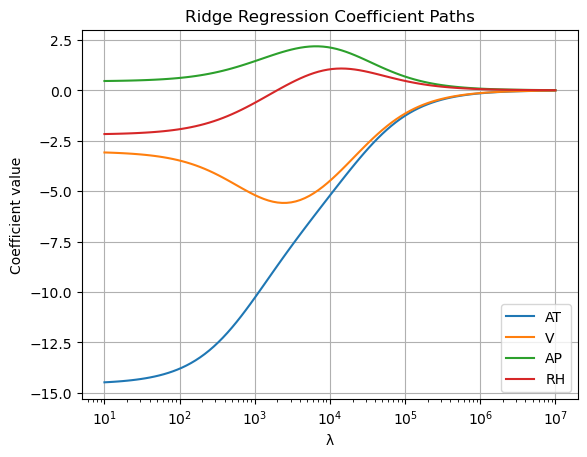

In [74]:
# Ridge regression
lambdas = np.logspace(1, 7, 100)
ridge_coefs = []
for lam in lambdas:
    ridge = Ridge(alpha=lam)
    ridge.fit(X_scaled, y)
    ridge_coefs.append(ridge.coef_)
ridge_coefs = np.array(ridge_coefs)

# Plot
plt.figure()
for i, f in enumerate(features):
    plt.plot(lambdas, ridge_coefs[:, i], label=f)

plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("Coefficient value")
plt.title("Ridge Regression Coefficient Paths")
plt.legend()
plt.grid()
plt.savefig("ridge_regularization.png")
plt.show()

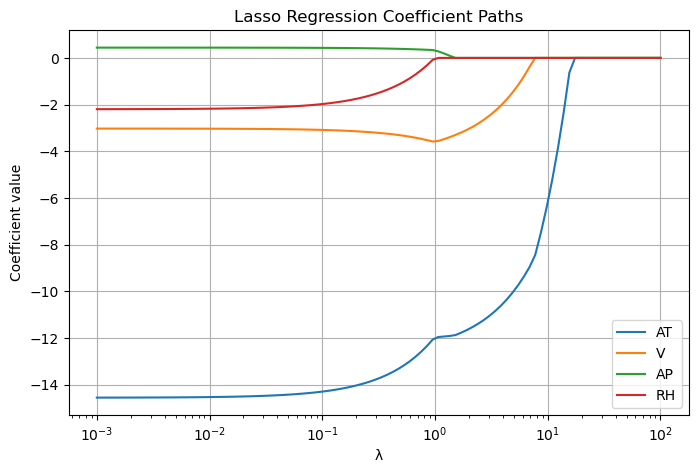

In [75]:
# Lasso
lambdas = np.logspace(-3, 2, 100)
lasso_coefs = []
for lam in lambdas:
    lasso = Lasso(alpha=lam, max_iter=10000)
    lasso.fit(X_scaled, y)
    lasso_coefs.append(lasso.coef_)

lasso_coefs = np.array(lasso_coefs)

# Plot
plt.figure(figsize=(8, 5))
for i, f in enumerate(features):
    plt.plot(lambdas, lasso_coefs[:, i], label=f)

plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("Coefficient value")
plt.title("Lasso Regression Coefficient Paths")
plt.legend()
plt.grid()
plt.savefig("lasso_regularization.png")
plt.show()